In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.animation as animation
import numpy as np
from PIL import Image
import pybullet as p
import io
import os

from pymanopt.manifolds import Euclidean, Sphere, Product

from SkillsSequencing.skills.mps.gmr.manifold_statistics import compute_frechet_mean, compute_weighted_frechet_mean
from SkillsSequencing.skills.mps.gmr.manifold_clustering import manifold_k_means, manifold_gmm_em
from SkillsSequencing.skills.mps.gmr.manifold_gmr import manifold_gmr

from SkillsSequencing.skills.mps.dynsys.CALVIN_DS import CALVINDynSysDataset

### Quaternion Math

In [2]:
def q_conjugate(q):
    w, x, y, z = q
    return (w, -x, -y, -z)

def qv_mult(q1, v1):
    q2 = (0.0,) + v1
    return q_mult(q_mult(q1, q2), q_conjugate(q1))[1:]

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return w, x, y, z

### Plot to Array Utils

In [3]:
def plt2arr(fig, draw=True):
    """
    need to draw if figure is not drawn yet
    """
    if draw:
        fig.canvas.draw()
    rgba_buf = fig.canvas.buffer_rgba()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.frombuffer(rgba_buf, dtype=np.uint8).reshape((h,w,4))
    return rgba_arr

### Calvin

In [4]:
skill = 'rotate_red_block_right'
dataset = CALVINDynSysDataset(skill=skill, state_type='pos_ori', is_quaternion=True, train=True, normalized=False, goal_centered=False, demos_dir='data/')

In [8]:
buffer = 0.05
minx = min(dataset.X[:, :, 0].flatten().numpy()) - buffer
maxx = max(dataset.X[:, :, 0].flatten().numpy()) + buffer

miny = min(dataset.X[:, :, 1].flatten().numpy()) - buffer
maxy = max(dataset.X[:, :, 1].flatten().numpy()) + buffer

minz = min(dataset.X[:, :, 2].flatten().numpy()) - buffer
maxz = max(dataset.X[:, :, 2].flatten().numpy()) + buffer

### Plotting

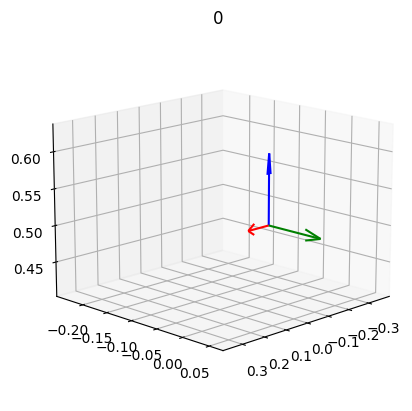

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


X = [1/10, 0, 0]
Y = [0, 1/10, 0]
Z = [0, 0, 1/10]
# origin = [0, 0, 0]
origin = dataset.X[0][0][:3]
OX, OY, OZ = zip(origin) 

ax.quiver(OX, OY, OZ, X[0],X[1], X[2], color='red')
ax.quiver(OX, OY, OZ, Y[0], Y[1], Y[2], color='green')
ax.quiver(OX, OY, OZ, Z[0],Z[1],Z[2], color='blue')
# ax.scatter(OX, OY, OZ, color='gray')
ax.view_init(elev=15, azim=45)
ax.set(xlim=(minx, maxx), ylim=(miny, maxy), zlim=(minz, maxz))
ax.set_title("0")
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
plt.show()
plt.close(fig)

### Plotting Quaternions "as-is" from the dataset

In [9]:
frames = []
X = [1/10, 0, 0]
Y = [0, 1/10, 0]
Z = [0, 0, 1/10]
rand_idx = np.random.randint(0, len(dataset.X)-1)
traj = dataset.X[rand_idx].numpy()
for idx, row in enumerate(traj):
    pos = row[:3]
    OX, OY, OZ = zip(pos) 
    q = row[3:]
    q = np.array([q[-1], q[0], q[1], q[2]])
    X = qv_mult(q, tuple(X))
    Y = qv_mult(q, tuple(Y))
    Z = qv_mult(q, tuple(Z))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(OX, OY, OZ, X[0], X[1], X[2], color='red')
    ax.quiver(OX, OY, OZ, Y[0], Y[1], Y[2], color='green')
    ax.quiver(OX, OY, OZ, Z[0], Z[1], Z[2], color='blue')
    for i in range(idx):
        ax.scatter(traj[i][0], traj[i][1], traj[i][2], color='gray')
    
    ax.view_init(elev=15, azim=60)
    ax.set(xlim=(minx, maxx), ylim=(miny, maxy), zlim=(minz, maxz))
    ax.set_title(skill + ' - ' + str(idx+1))
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_zticks([])

    frames.append(plt2arr(fig, True))
    plt.close(fig)
    X = [1/10, 0, 0]
    Y = [0, 1/10, 0]
    Z = [0, 0, 1/10]

gif = [Image.fromarray(img) for img in frames]
gif[0].save(f"quat_demo_{skill}.gif", save_all=True, append_images=gif[1:], duration=150, loop=0)
print(rand_idx)

136


### Toy Example - Rotation about an axis

In [8]:
def getQuaternionFromAxisAngle(axis=(0, 0, 0), angle=90, with_noise=False):
    ax, ay, az = axis
    qw = np.cos((angle/2.0)*(np.pi/180))
    qx = ax * np.sin((angle/2.0)*(np.pi/180))
    qy = ay * np.sin((angle/2.0)*(np.pi/180))
    qz = az * np.sin((angle/2.0)*(np.pi/180))
    
    if with_noise:
        angle += np.random.normal(0, 5)
        qw += np.random.normal(0, 0.01)
        qx += np.random.normal(0, 0.01)
        qy += np.random.normal(0, 0.01)
        qz += np.random.normal(0, 0.01)
        
    return (qw, qx, qy, qz) / np.linalg.norm((qw, qx, qy, qz))

### 90 deg rotation about y axis

In [9]:
getQuaternionFromAxisAngle(axis=(1, 1, 1), angle=90, with_noise=True)

array([0.50667445, 0.49978665, 0.49366   , 0.49979407])

In [10]:
buffer = 0.1
minx = -buffer
maxx = +buffer

miny = - buffer
maxy = + buffer

minz = - buffer
maxz = + buffer

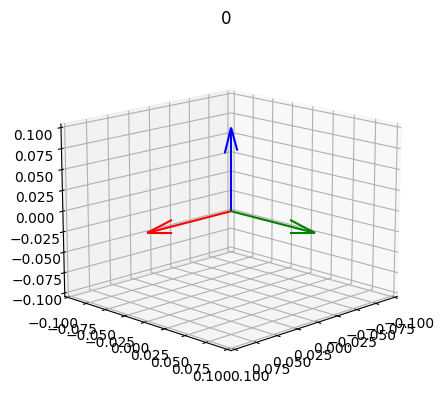

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


X = [1/10, 0, 0]
Y = [0, 1/10, 0]
Z = [0, 0, 1/10]
origin = [0.0, 0.0, 0.0]
# origin = dataset.X[0][0][:3]
OX, OY, OZ = zip(origin) 

ax.quiver(OX, OY, OZ, X[0],X[1], X[2], color='red')
ax.quiver(OX, OY, OZ, Y[0], Y[1], Y[2], color='green')
ax.quiver(OX, OY, OZ, Z[0],Z[1],Z[2], color='blue')
# ax.scatter(OX, OY, OZ, color='gray')
ax.view_init(elev=15, azim=45)
ax.set(xlim=(minx, maxx), ylim=(miny, maxy), zlim=(minz, maxz))
ax.set_title("0")
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
plt.show()
plt.close(fig)

In [12]:
frames = []
X = [1/10, 0, 0]
Y = [0, 1/10, 0]
Z = [0, 0, 1/10]

rot_name = "Rotation along z axis opposite - with noise"
max_steps = 60
for i in range(max_steps):
    OX, OY, OZ = zip(origin) 
    q = getQuaternionFromAxisAngle(axis=(1, 1, 1), angle=-i*3,  with_noise=True)
    
    X = qv_mult(q, tuple(X))
    Y = qv_mult(q, tuple(Y))
    Z = qv_mult(q, tuple(Z))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(OX, OY, OZ, X[0], X[1], X[2], color='red', label="x")
    ax.quiver(OX, OY, OZ, Y[0], Y[1], Y[2], color='green', label='y')
    ax.quiver(OX, OY, OZ, Z[0], Z[1], Z[2], color='blue', label="z")
    
    ax.view_init(elev=15, azim=45)
    ax.set(xlim=(minx, maxx), ylim=(miny, maxy), zlim=(minz, maxz))
    ax.set_title(rot_name + ' - ' + str(i))
    ax.legend()
    frames.append(plt2arr(fig, True))
    plt.close(fig)
    X = [1/10, 0, 0]
    Y = [0, 1/10, 0]
    Z = [0, 0, 1/10]

gif = [Image.fromarray(img) for img in frames]
gif[0].save(f"quat_rotation_z.gif", save_all=True, append_images=gif[1:], duration=150, loop=0)

### Create Toy Dataset and learn a GMM

In [8]:
max_data = 10
traj_len = 62
dt = 2/30
sampling_dt = 1/30

train = np.empty(shape=(max_data, traj_len, 4))
for i in range(max_data):
    traj = np.empty(shape=(traj_len, 4))
    for j in range(traj_len):
        traj[j] = getQuaternionFromAxisAngle(axis=(1, 1, 1), angle=-j*3,  with_noise=True)
    train[i] = traj
train_dX = (train[:, 2:, :] - train[:, :-2, :]) / dt
train_X = train[:, 1:-1, :]

# Validation set
val = np.empty(shape=(max_data, traj_len, 4))
for i in range(max_data):
    traj = np.empty(shape=(traj_len, 4))
    for j in range(traj_len):
        traj[j] = getQuaternionFromAxisAngle(axis=(1, 1, 1), angle=-j*3,  with_noise=True)
    val[i] = traj
val_dX =  (val[:, 2:, :] - val[:, :-2, :]) / dt
val_X = val[:, 1:-1, :]

In [9]:
train[0][0]

array([ 9.99943114e-01,  2.43062994e-03,  2.74194061e-04, -1.03820193e-02])

In [10]:
nb_data = train_X[0].shape[0]
nb_data_sup = 62
nb_samples = train.shape[0]
input_dim = 4
output_dim = 4

In [11]:
# Stack position and velocity data
demos_xdx = [np.hstack([train_X[i], train_dX[i]]) for i in range(nb_samples)]

# Stack demos
demos_np = demos_xdx[0]
for i in range(1, nb_samples):
    demos_np = np.vstack([demos_np, demos_xdx[i]])

In [12]:
X = demos_np[:, :input_dim]
Y = demos_np[:, input_dim:]

In [13]:
data = np.empty((X.shape[0], 2), dtype=object)
for n in range(X.shape[0]):
    data[n] = [X[n], Y[n]]

In [14]:
data.shape

(600, 2)

In [18]:
input_manifold = Sphere(input_dim)
output_manifold = Sphere(output_dim)
manifold = Product([input_manifold, output_manifold])

# Number of clusters
nb_clusters = 2

In [19]:
data[0]

array([array([ 0.99837575, -0.0241723 , -0.03031234, -0.04174603]),
       array([-0.0599517 , -0.79112574, -0.79863767, -0.63145569])],
      dtype=object)

In [20]:
# K-means
km_means, km_assignments = manifold_k_means(manifold, data, nb_clusters=nb_clusters)

# GMM
initial_covariances = np.concatenate(nb_clusters * [np.eye(input_dim+output_dim)[None]], 0)
initial_priors = np.zeros(nb_clusters)
for k in range(nb_clusters):
    initial_priors[k] = np.sum(km_assignments == k) / len(km_assignments)
gmm_means, gmm_covariances, gmm_priors, gmm_assignments = manifold_gmm_em(manifold, data, nb_clusters,
                                                                          initial_means=km_means,
                                                                          initial_covariances=initial_covariances,
                                                                          initial_priors=initial_priors)
outdir = f'skill_ds/ori/rotate/gmm/'
os.makedirs(outdir, exist_ok=True)
filename = outdir + f'gmm_params_toy{nb_clusters}.npz'
np.savez(filename, gmm_means=gmm_means, gmm_covariances=gmm_covariances, gmm_priors=gmm_priors)

Converged after 18 iterations: 2.805e+01


In [ ]:
# X_val = val_X[0]
# for i in range(1, val_X.shape[0]):
#     X_val = np.vstack([X_val, val_X[i]])

In [22]:
X = demos_np[:, :input_dim]
Y = demos_np[:, input_dim:]
rand_idx = np.random.choice(np.arange(0, len(X), nb_data))
# rand_idx = 0
sampled_path = []
x0 = np.copy(X[rand_idx, :])
goal = np.copy(X[rand_idx+nb_data-1, :])
new_x = x0

In [23]:
import pdb

for i in range(60):
#     pdb.set_trace()
    x_dot, sigma_gmr, H = manifold_gmr(new_x.reshape(1, -1), manifold, gmm_means, gmm_covariances, gmm_priors)
    new_x = new_x + dt * x_dot
    new_x = new_x / np.linalg.norm(new_x)
    
    sampled_path.append(new_x)
    
#     if np.linalg.norm(new_x - goal) <= 0.03:
#         break
sampled_path = np.array(sampled_path).squeeze(1)
true_path = X[rand_idx:rand_idx+nb_data]
print(rand_idx, len(sampled_path))

300 60


In [24]:
sampled_path

array([[ 0.99414576, -0.03174278, -0.0679035 , -0.07781856],
       [ 0.98552449, -0.06924289, -0.11124868, -0.10756686],
       [ 0.97272116, -0.11268848, -0.14487655, -0.14186487],
       [ 0.96890756, -0.0836444 , -0.18123879, -0.14619935],
       [ 0.94826181, -0.10549771, -0.2476876 , -0.16828734],
       [ 0.93437112, -0.09772437, -0.25921584, -0.22407076],
       [ 0.92419292, -0.16287405, -0.24914857, -0.23929999],
       [ 0.90359293, -0.17757899, -0.2877364 , -0.26304617],
       [ 0.88140853, -0.18242364, -0.31514748, -0.30086989],
       [ 0.85308101, -0.18573721, -0.32773453, -0.36103264],
       [ 0.78745106, -0.26073957, -0.422446  , -0.36534242],
       [ 0.74622832, -0.27265959, -0.44628663, -0.41185954],
       [ 0.70379445, -0.30447609, -0.47396676, -0.43280849],
       [ 0.65985663, -0.33541273, -0.49914127, -0.45049476],
       [ 0.61409086, -0.36318134, -0.5220414 , -0.46740186],
       [ 0.5677304 , -0.38871379, -0.54199105, -0.48252408],
       [ 0.521001  , -0.

In [25]:
frames = []
X = [1/10, 0, 0]
Y = [0, 1/10, 0]
Z = [0, 0, 1/10]

# for idx, q in enumerate(true_path):
# #     q = np.array([q[-1], q[0], q[1], q[2]])
#     X = qv_mult(q, tuple(X))
#     Y = qv_mult(q, tuple(Y))
#     Z = qv_mult(q, tuple(Z))
    
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.quiver(OX, OY, OZ, X[0], X[1], X[2], color='red')
#     ax.quiver(OX, OY, OZ, Y[0], Y[1], Y[2], color='green')
#     ax.quiver(OX, OY, OZ, Z[0], Z[1], Z[2], color='blue')
    
#     ax.view_init(elev=15, azim=40)
#     ax.set(xlim=(minx, maxx), ylim=(miny, maxy), zlim=(minz, maxz))
#     ax.set_title('rotation GT - ' + str(idx+1))
# #     ax.set_xticks([])
# #     ax.set_yticks([])
# #     ax.set_zticks([])

#     frames.append(plt2arr(fig, True))
#     plt.close(fig)
#     X = [1/10, 0, 0]
#     Y = [0, 1/10, 0]
#     Z = [0, 0, 1/10]

for idx, q in enumerate(sampled_path):
#     q = np.array([q[-1], q[0], q[1], q[2]])
    X = qv_mult(q, tuple(X))
    Y = qv_mult(q, tuple(Y))
    Z = qv_mult(q, tuple(Z))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(OX, OY, OZ, X[0], X[1], X[2], color='red')
    ax.quiver(OX, OY, OZ, Y[0], Y[1], Y[2], color='green')
    ax.quiver(OX, OY, OZ, Z[0], Z[1], Z[2], color='blue')
    
    ax.view_init(elev=15, azim=45)
    ax.set(xlim=(minx, maxx), ylim=(miny, maxy), zlim=(minz, maxz))
    ax.set_title('rotation along xyz - gmm sampled - ' + str(idx+1))

    frames.append(plt2arr(fig, True))
    plt.close(fig)
    X = [1/10, 0, 0]
    Y = [0, 1/10, 0]
    Z = [0, 0, 1/10]

gif = [Image.fromarray(img) for img in frames]
gif[0].save("quat_gmm_xyz.gif", save_all=True, append_images=gif[1:], duration=150, loop=0)
print(rand_idx)

300


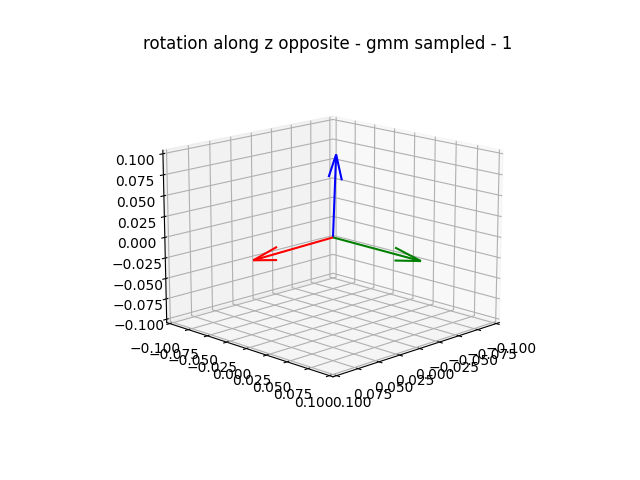

In [131]:
gif[0]

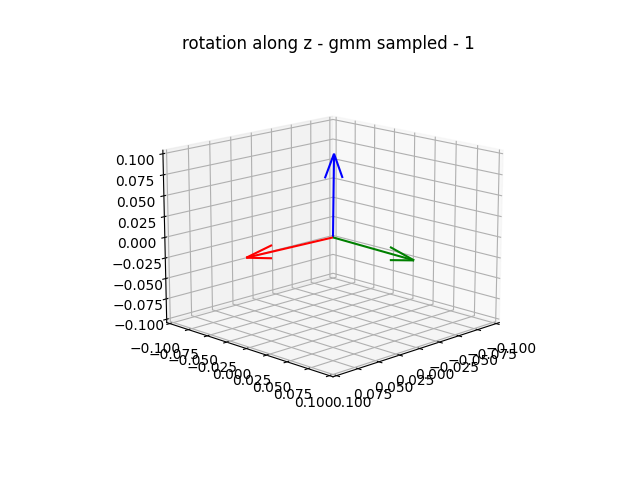

In [63]:
gif[len(true_path)]